Chapter 5 - Lab on the Finite Element Method
============================================

# Exercise I

Let $f\in L^{2}(0,1)$.

Consider

$$ (5.1)\quad\left\{
    \begin{array}{ll}
       - \displaystyle u^{\prime\prime}=f \quad \textrm{in}\ ]0,1[,\\
       u(0)=\alpha\quad\textrm{and}\quad u(1)=\beta. 
    \end{array}\right.$$
                                         
with $\alpha,\beta\in\mathbb{R}$.

In this notebook, we will need several librairies:

In [1]:
# Two standard librairies for mathematical functions

import math
import numpy as np


# A standard library for plotting

import matplotlib.pyplot as plt


# Functions for numerical quadrature
# (numerical approxmation of an integral)

from scipy.integrate import quad
from scipy import special

## Question 1

To determine a PDE with homogeneous Dirichlet conditions that is equivalent to (5.1), we use the lifting technique.

It is sufficient to chose $u_{0}$ whose value at 0 is $\alpha$ and whose value at $\beta$ is $1$. For instance, let 
$u_0(x)=\alpha (1-x)+\beta x$ an consider $\tilde{u}=u-u_0$. 
Function $\tilde{u}$ is a solution to

$$\left \{
    \begin{array}{l}
      - \displaystyle \tilde{u}''= g\quad\textrm{in} ]0,1[,\\
      \tilde{u}(0)=0\quad\textrm{and}\quad \tilde{u}(1)=0. 
    \end{array}
   \right. $$

where $g(x) = f(x)+u_{0}''(x)$.

This choice of $u_0$ leads to $u_0''=0$, therefore $g=f$ (subseqently there is no need to define another function).

In [2]:
def u0(x):
    return alpha*(1-x) + beta*x

# We will need to define alpha and beta before using this function.

## Question 2

We want to write the variational formulation.
We follow the steps indicated in the handout example https://cagnol.link/pde4handout

To simplify the notations, in this question we omit the tilde and write $u$ instead of $\tilde{u}$.

We obtain the variational formulation $$a(u,\varphi)=l(\varphi)$$
where $a$ is defined from $C^1_0([0,1])\times C^1_0([0,1])$ to ${\mathbb{R}}$ by
$$a(u,v)=\int_0^1 u'v'$$
and $l$ is defined from $C^1_0([0,1])$ to $\mathbb {R}$ by $$l(v)=\int_0^1 gv$$

## Question 3

Let $J\in\mathbb{N}^*$ and $$h=\frac{1}{J+1}$$ 

In [3]:
J=10       # Number of nodes - ends excluded
h=1/(J+1) # Discretizaton step

Consider a subdivision $(x_j)_{j\in\{0,...,J+1\}}$ of $[0,1]$ where $x_j=jh$.
Let $P_1$ be the set of polynomials of degree lower than 1 and


$$H_{0,h}=  \{v \in C^0([0,1])\ |\ \forall j\in\{0,...,J\},\;v_{|[x_j,x_{j+1}]}\in P_1\ \textrm{and}\ v(0)=v(1)=0\}$$

We note $N_h=\operatorname{dim} H_{0,h}$.
We have $N_h=J$.

Consider the basis $(\phi_1,...,\phi_{N_h})$ of $H_{0,h}$ composed of hat functions

$$\phi_j(x)=\left\{\begin{array}{lll}
    0 & \textrm{if} & x\in[0,(j-1)h[\\
    \frac{1}{h}x-j+1 & \textrm{if} & x\in [(j-1)h,jh]\\
    -\frac{1}{h}x+j+1 & \textrm{if} & x\in ]jh,(j+1)h]\\
    0 & \textrm{if} & x\in](j-1)h,1]
    \end{array}
    \right.$$

In [4]:
# We define the hat functions

def phi(x,j):
    if x<(j-1)*h:
        return 0
    elif x<j*h:
        return 1+(x-j*h)/h
    elif x<(j+1)*h:
        return 1-(x-j*h)/h
    else: # x>(j+1)*h
        return 0

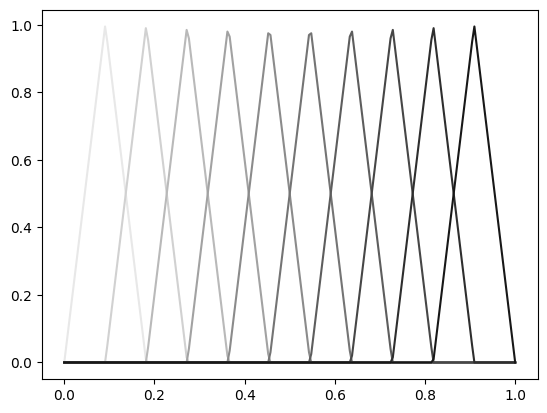

In [5]:
# We plot with several shades of gray

# Number of points to represent the function
Nx = 200 

x = np.arange(Nx,dtype=float)
y = np.arange(Nx,dtype=float)

for j in range(1,J+1): # j is in between 1 and J. See the definition of range() in case of doubt!

    s = 0
    
    for t in np.linspace(0.0,1.0,Nx):
        x[s] = t
        y[s] = phi(t,j)
        s = s+1
    
    color = 1-j/(J+1)
    
    plt.plot(x,y,color=(color,color,color))

plt.show()

# Exercise V

## Question 1
$$\forall i\in[1,J],\ a(u_h,\phi_i)=l(\phi_i)$$ 
iff $$\forall i\in[1,J],\ a\left(\sum_{j=1}^Ju_h^j\phi_j,\phi_i\right)=l(\phi_i)$$
iff $$\forall i\in[1,J],\ \sum_{j=1}^Ju_h^ja(\phi_j,\phi_i)=l(\phi_i)$$
iff $$A_hU_h=F_h$$
Let us note
- $A_h$ the $J\times J$ matrix whose coefficients are $a(\phi_j,\phi_i)$ at line $i$ and column $j$
- $U_h\in\mathbb{R}^J$ the vector whose components are $u_h^1,\ldots,u_h^J$
- $F_h\in\mathbb{R}^J$ the vector whose $i$-th component is $l(\phi_i)$

## Question 2
To compute $A_h$, we can: 
- Compute $a(\phi_i,\phi_j)$ by quadrature
- Compute $a(\phi_i,\phi_j)$ algebraically.

Thus, there are two methods.

Here, we shall computer $a(\varphi_i,\varphi_j)$ by quadrature.
In exercise VII, we will compute it algebraically (or use the algebraic computation carried out in the lecture).

In [6]:
# We need the derivative of the hat functions

def phi_prime(x,j):
    if x<(j-1)*h:
        return 0
    elif x<j*h:
        return 1/h
    elif x<(j+1)*h:
        return -1/h
    else: # x>(j+1)*h
        return 0

In [7]:
def phi_prime_phi_prime(x,i,j):
    # Returns phi_i'(x)*phi_j'(x)
    return phi_prime(x,i)*phi_prime(x,j)

In [8]:
Ah = np.zeros((J, J), float)

for i in range(J):
    for j in range(J):
        integral, erreur = quad(phi_prime_phi_prime,0,1,args=(i+1,j+1))
        Ah[i,j] = integral

# Beaware the components of Ah are numbered 0 to J-1 while the basis elements are numbered 1 to J.

In [9]:
print(Ah)

[[ 22. -11.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-11.  22. -11.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -11.  22. -11.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -11.  22. -11.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -11.  22. -11.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -11.  22. -11.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -11.  22. -11.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -11.  22. -11.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -11.  22. -11.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -11.  22.]]


## Question 3

Let $f(x)=12x^2$ and $\alpha=1$, $\beta=2$.

In [10]:
alpha = 1
beta = 2

def f(x):
    return 12*x*x

Let us compute $F_h$.

In [11]:
def f_times_phi(x,j):
    return f(x)*phi(x,j)

In [12]:
# We now build Fh

Fh = np.zeros((J), float)

for i in range(J):
    j = i+1
    integral, erreur = quad(f_times_phi, 0, 1, args=(j))
    Fh[i] = integral

In [13]:
print(Fh)

[0.01051841 0.03756574 0.08264463 0.14575507 0.22689707 0.32607062
 0.44327573 0.5785124  0.73178062 0.90308039]


## Question 4

Let us solve $A_hU_h=F_h$ for $U_h$.

In [14]:
Uh = np.linalg.solve(Ah,Fh)

In [15]:
print(Uh)

[0.09084079 0.18072536 0.26719486 0.34615122 0.41185711 0.456936
 0.47237211 0.44751042 0.37005669 0.22607745]


## Question 5

In [16]:
def u_lifted(x): # u_tilde
    
    val = 0
    
    for j in range(1,J+1):
        val = val + Uh[j-1]*phi(x,j)
        
    return(val)

In [17]:
def u_unlifted(x):
    
    return u_lifted(x) + u0(x) 

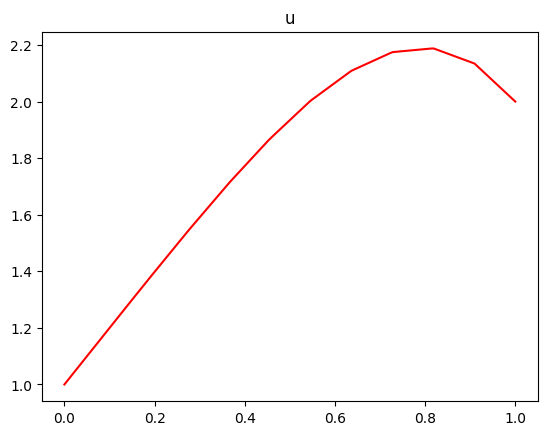

In [18]:
# Let's plot

# Number of points used to represent the function
Nx = 200 

x = np.arange(Nx,dtype=float)
y = np.arange(Nx,dtype=float)

s = 0

for t in np.linspace(0.0,1.0,Nx):
    x[s] = t
    y[s] = u_unlifted(t)
    s = s+1
        
plt.title("u")
plt.plot(x,y,'r')
plt.show()

## Question 6
We can computed the solution of the equation by hand by double integrating $f$ and fixing the two constants that appear from $u(0)$ and $u(1)$. We then find $$u(x)=-x^4+2x+1$$
Let us plot this function.

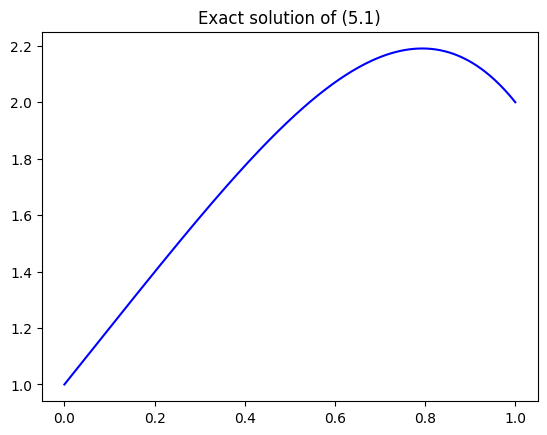

In [19]:
z = np.arange(Nx,dtype=float)

s = 0

for t in np.linspace(0.0,1.0,Nx):
    z[s] = -t**4+2*t+1 
    s = s+1
    
plt.title("Exact solution of (5.1)")
plt.plot(x,z,'b')
plt.show()

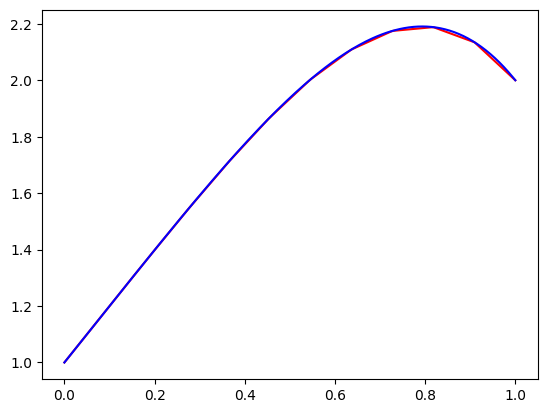

In [20]:
plt.plot(x,y,'r')
plt.plot(x,z,'b')

In [21]:
max(abs(y-z))

0.011301120498002692

# Exercise VI

The computed solution gets closer to the exact solution as h goes to 0 but when h is too small we have a weird phenomenon (that will be explained in Chapter 7).

# Exercise VII

Construction of the stiffness matrix based on the lecture. We determine directly instead of working by quadrature.

In [24]:
Ah_lecture = np.zeros((J, J), float)

for i in range(J):
    j = i+1
    Ah_lecture[i,i] = 2.0/h

for i in range(J-1):
    j = i+1
    Ah_lecture[i,i+1] = -1/h
    Ah_lecture[i+1,i] = -1/h

In [25]:
print(Ah_lecture)

[[ 22. -11.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-11.  22. -11.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -11.  22. -11.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -11.  22. -11.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -11.  22. -11.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -11.  22. -11.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -11.  22. -11.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -11.  22. -11.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -11.  22. -11.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -11.  22.]]


In [26]:
print(Ah)

[[ 22. -11.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-11.  22. -11.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -11.  22. -11.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -11.  22. -11.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -11.  22. -11.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -11.  22. -11.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -11.  22. -11.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -11.  22. -11.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -11.  22. -11.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -11.  22.]]


# Exercise III

Let us consider $\Omega=[0,1]\times[0,1]$, the function $f\in L^{2}(\Omega)$, and the PDE

$$(5.2)\quad\left\{
    \begin{array}{ll}
       - \Delta \displaystyle u=f &
       \textrm{in}\ \Omega,\\
       u=0&\textrm{on}\ \partial\Omega
    \end{array}\right.
$$

In [1]:
# We will need these libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import time


# We will also need...

from matplotlib import cm
from mpl_toolkits import mplot3d
from scipy import integrate

## Question 1

## Question 1

We want to write the variational formulation. We follow the steps indicated in the handout example https://cagnol.link/pde4handout

The obtained variational formulation is $$a(u,\varphi)=l(\varphi)$$
where $a$ is defined from $H^1_0(\Omega)\times H^1_0(\Omega)$ to ${\mathbb{R}}$ by
$$a(u,v)=\int_{\Omega} \nabla u \cdot \nabla v$$
and $l$ is defined from $H^1_0(\Omega)$ to $\mathbb {R}$ by $$l(v)=\int_{\Omega} gv$$
 

## Question 2

Define $L_x$ and $L_y$. Let $\Omega=[0,L_x]\times[0,L_y]$.

We need to decide how fine will be the meshing of $[0,L_x]$ and $[0,L_y]$ with $J_x$ and $J_y$ respectively.

Regarding $[0,L_x]$, we subdivise the interval with the points $0,...,J_x+1$. There are $J_x+2$ points. 
The interior points (ends excluded) will be numbered 1 to $J_x$.

Similarly, for $[0,L_y]$, we subdivise with points $0,...,J_y+1$. There are $J_y+2$ points.  The interior points (ends excluded) will be numbered 1 to $J_y$.

Since both subdivisions are uniform, the step (i.e. the length bewteen two points in the discretization) is 
$$h_x = \frac{L_x}{J_x+1}$$
and similarly:
$$h_y = \frac{L_y}{J_y+1}$$


In [2]:
Lx = 6
Ly = 6

Jx = 5
Jy = 5

hx = Lx / (Jx+1)
hy = Ly / (Jy+1)

Let $i\in\{1,...,J_y\}$ and $j\in\{1,...,J_x\}$.

Let $(x,y)\in\Omega$. We would like to find out if $(x,y)$ is in the hexagon or not.
If it is, we would like to know in which triangle. It is what this function is doing:

In [3]:
def QuelTriangle(x,y,j,i):

    if x>=j*hx and x<=(j+1)*hx and y>=i*hy and y<=(i+1)*hy: 
        # North East
        
        if (x-j*hx)*hy/hx > (y-i*hy):            
            return 'T1'
        else: 
            return 'T2'
  

    elif x<=j*hx and x>=(j-1)*hx and y>=i*hy and y<=(i+1)*hy: 
        # North West
        
        if y-hy*i <= (hy/hx)*(x-(j-1)*hx):
            return 'T3'
        else:
            return 'off-support'
 

    elif x<=j*hx and x>=(j-1)*hx and y<=i*hy and y>=(i-1)*hy: 
        # South West
        
        if (x-j*hx)*hy/hx < (y-i*hy): 
            return 'T4'
        else:
            return 'T5'
        
        
    elif x>=j*hx and x<=(j+1)*hx and y<=i*hy and y>=(i-1)*hy: 
        # South East
        
        if y>= hy/hx*x + hy*i-hy*(j+1):
            return 'T6'
        else:
            return 'off-support'
    
    else: 
        return 'off-support'

We determine the equation of the six planes that constitute the faces of the six-sided pyramid, whose apex is on $(j h_x,i h_y,1)$. We derive the formula for $\phi_{j,i}(x,y)$

In [4]:
def phi_ji(x,y,j,i):
    
    if x<0 or x>Lx or y<0 or y>Ly:
        return 0
    
    match QuelTriangle(x,y,j,i) :
        case 'T1':
            return -x/hx + j+1
        case 'T2':
            return -y/hy + i+1
        case 'T3':
            return x/hx - y/hy + i-j+1
        case 'T4':
            return x/hx + 1-j
        case 'T5':
            return y/hy + 1-i
        case 'T6':
            return -x/hx + y/hy + 1-i+j
        case 'off-support':
            return 0
    

SyntaxError: invalid syntax (139235024.py, line 6)

**Note:** if you have a syntax error with match, it is because your version of Python is strictly less than 3.10. In this case, you can rewrite the above with if ... elif ... else.

You can check your Python version with the following command:

In [5]:
print("Python version : ",sys.version)

Python version :  3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41) 
[Clang 16.0.6 ]


In [6]:
def phi_ji(x,y,j,i):
    
    if x<0 or x>Lx or y<0 or y>Ly:
        return 0
    
    if   QuelTriangle(x,y,j,i) == "T1":
        return -x/hx + j+1
    elif QuelTriangle(x,y,j,i) == 'T2':
        return -y/hy + i+1
    elif QuelTriangle(x,y,j,i) == 'T3':
        return x/hx - y/hy + i-j+1
    elif QuelTriangle(x,y,j,i) == 'T4':
        return x/hx + 1-j
    elif QuelTriangle(x,y,j,i) == 'T5':
        return y/hy + 1-i
    elif QuelTriangle(x,y,j,i) == 'T6':
        return -x/hx + y/hy + 1-i+j
    elif QuelTriangle(x,y,j,i) == 'off-support':
        return 0

In [7]:
def Represent_phi (j,i):
    
    phi_ji_vect = np.vectorize(phi_ji, otypes=[np.float64])

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    x = np.arange(0, Lx, 0.01)
    y = np.arange(0, Ly, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = phi_ji_vect(X,Y,j,i)

    
    # We represent the 3D surface
    
    surf = ax.plot_surface(X, Y, Z, alpha=0.9)

    plt.title("phi_{%d,%d}"%(j,i))
    plt.show()
    
    
    # ... and the contour plot
    
    fig, ax = plt.subplots()
    PCM=ax.contourf(X, Y, Z)
    
    plt.title("phi_{%d,%d}"%(j,i))
    plt.colorbar(PCM, ax=ax) 
    plt.show()